# WCP-L2D: Weighted Conformal Prediction for Learning to Defer

Post-hoc adaptive framework using DRE-weighted conformal prediction
to optimize deferral decisions under distribution shift (CheXpert → NIH).

**Approach**: Per-pathology binary classification with RAPS-based conformal
prediction. For each pathology, the model predicts positive/negative, and
defers when the prediction set is ambiguous (|C(x)| ≠ 1).

In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.pathologies import COMMON_PATHOLOGIES
from wcp_l2d.label_utils import extract_binary_labels
from wcp_l2d.dre import AdaptiveDRE
from wcp_l2d.conformal import ConformalPredictor, WeightedConformalPredictor
from wcp_l2d.evaluation import (
    evaluate_max_logit,
    evaluate_standard_cp,
    evaluate_wcp,
    plot_accuracy_rejection_curve,
    plot_coverage_comparison,
    summary_table,
)

SEED = 42
EXPERT_ACCURACY = 0.85
FEATURE_DIR = Path("../data/features")
TARGET_PATHOLOGY = "Effusion"  # Primary pathology for detailed analysis

np.random.seed(SEED)
torch.manual_seed(SEED)
print(f"Target pathology: {TARGET_PATHOLOGY}")
print("Setup complete.")

Target pathology: Effusion
Setup complete.


## 1. Load Features & Prepare Binary Labels

In [33]:
# Load pre-extracted DenseNet121 features
chexpert = ExtractedFeatures.load(
    FEATURE_DIR / "chexpert_densenet121-res224-chex_features.npz"
)
nih = ExtractedFeatures.load(FEATURE_DIR / "nih_densenet121-res224-chex_features.npz")

print(f"CheXpert raw: {chexpert.features.shape}")
print(f"NIH raw:      {nih.features.shape}")

# Extract binary labels for the target pathology
chex_feats, chex_labels, chex_mask = extract_binary_labels(
    chexpert.features, chexpert.labels, COMMON_PATHOLOGIES, TARGET_PATHOLOGY
)
nih_feats, nih_labels, nih_mask = extract_binary_labels(
    nih.features, nih.labels, COMMON_PATHOLOGIES, TARGET_PATHOLOGY
)

print(f"\nAfter filtering (non-NaN {TARGET_PATHOLOGY}):")
print(
    f"  CheXpert: {len(chex_labels)} (pos={chex_labels.sum()}, neg={len(chex_labels) - chex_labels.sum()}, prevalence={chex_labels.mean():.3f})"
)
print(
    f"  NIH:      {len(nih_labels)} (pos={nih_labels.sum()}, neg={len(nih_labels) - nih_labels.sum()}, prevalence={nih_labels.mean():.3f})"
)

CheXpert raw: (64534, 1024)
NIH raw:      (30805, 1024)

After filtering (non-NaN Effusion):
  CheXpert: 44140 (pos=20640, neg=23500, prevalence=0.468)
  NIH:      30805 (pos=1240, neg=29565, prevalence=0.040)


## 2. Data Splits

In [34]:
# CheXpert: train (60%), calibration (20%), test (20%)
chex_train_feats, chex_temp_feats, chex_train_labels, chex_temp_labels = (
    train_test_split(
        chex_feats, chex_labels, test_size=0.4, random_state=SEED, stratify=chex_labels
    )
)
chex_cal_feats, chex_test_feats, chex_cal_labels, chex_test_labels = train_test_split(
    chex_temp_feats,
    chex_temp_labels,
    test_size=0.5,
    random_state=SEED,
    stratify=chex_temp_labels,
)

# NIH: pool (50% of ALL features for DRE, no labels needed) + test (50% of labeled)
rng = np.random.RandomState(SEED)
nih_all_perm = rng.permutation(len(nih.features))
nih_pool_feats_all = nih.features[nih_all_perm[: len(nih.features) // 2]]

nih_pool_feats_labeled, nih_test_feats, nih_pool_labels, nih_test_labels = (
    train_test_split(
        nih_feats, nih_labels, test_size=0.5, random_state=SEED, stratify=nih_labels
    )
)

print(f"CheXpert train: {len(chex_train_labels)} (pos={chex_train_labels.sum()})")
print(f"CheXpert cal:   {len(chex_cal_labels)} (pos={chex_cal_labels.sum()})")
print(f"CheXpert test:  {len(chex_test_labels)} (pos={chex_test_labels.sum()})")
print(f"NIH pool (DRE): {len(nih_pool_feats_all)} (all features, unlabeled)")
print(f"NIH test:       {len(nih_test_labels)} (pos={nih_test_labels.sum()})")

CheXpert train: 26484 (pos=12384)
CheXpert cal:   8828 (pos=4128)
CheXpert test:  8828 (pos=4128)
NIH pool (DRE): 15402 (all features, unlabeled)
NIH test:       15403 (pos=620)


## 3. Train Binary Classifier

In [35]:
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(chex_train_feats)
X_cal = scaler.transform(chex_cal_feats)
X_test_chex = scaler.transform(chex_test_feats)
X_test_nih = scaler.transform(nih_test_feats)

# Binary logistic regression for target pathology
clf = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    C=1.0,
    random_state=SEED,
)
clf.fit(X_train, chex_train_labels)

# Evaluate
print(f"Classifier performance ({TARGET_PATHOLOGY}):")
for name, X, y in [
    ("CheXpert train", X_train, chex_train_labels),
    ("CheXpert cal", X_cal, chex_cal_labels),
    ("CheXpert test", X_test_chex, chex_test_labels),
    ("NIH test", X_test_nih, nih_test_labels),
]:
    acc = clf.score(X, y)
    proba = clf.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    print(f"  {name:<16} acc={acc:.4f}  AUC={auc:.4f}")


# Get logits for CP (2-class: [logit_neg, logit_pos])
# decision_function returns scalar for binary; stack to get 2-class logits
def get_binary_logits(clf, X):
    d = clf.decision_function(X)  # [N] scalar
    return np.column_stack([-d, d])  # [N, 2] logits for class 0 and 1


cal_logits = get_binary_logits(clf, X_cal)
test_chex_logits = get_binary_logits(clf, X_test_chex)
test_nih_logits = get_binary_logits(clf, X_test_nih)

print(f"\nLogits shape: {cal_logits.shape}")

Classifier performance (Effusion):
  CheXpert train   acc=0.8222  AUC=0.8963
  CheXpert cal     acc=0.8068  AUC=0.8751
  CheXpert test    acc=0.8090  AUC=0.8771
  NIH test         acc=0.9151  AUC=0.8170

Logits shape: (8828, 2)


## 4. Adaptive DRE

In [36]:
# Fit DRE with PCA(4) — lower dims to regularize the domain classifier
# (CheXpert vs NIH features are too separable in higher dims)
dre = AdaptiveDRE(n_components=4, weight_clip=20.0, random_state=SEED)
dre.fit(
    source_features=chex_cal_feats,
    target_features=nih_pool_feats_all,
)

# Compute weights for calibration and test sets
cal_weights = dre.compute_weights(chex_cal_feats)
test_nih_weights = dre.compute_weights(nih_test_feats)

# Diagnostics
diag = dre.diagnostics(chex_cal_feats)
print("DRE Diagnostics:")
print(f"  Domain classifier AUC: {diag.domain_auc:.4f}")
print(f"  ESS: {diag.ess:.1f} / {len(cal_weights)} = {diag.ess_fraction:.3f}")
print(f"  Weights: mean={diag.weight_mean:.4f}, std={diag.weight_std:.4f}")
print(
    f"           min={diag.weight_min:.6f}, max={diag.weight_max:.4f}, median={diag.weight_median:.4f}"
)

DRE Diagnostics:
  Domain classifier AUC: 0.9606
  ESS: 563.7 / 8828 = 0.064
  Weights: mean=0.6056, std=2.3188
           min=0.000001, max=20.0000, median=0.0460


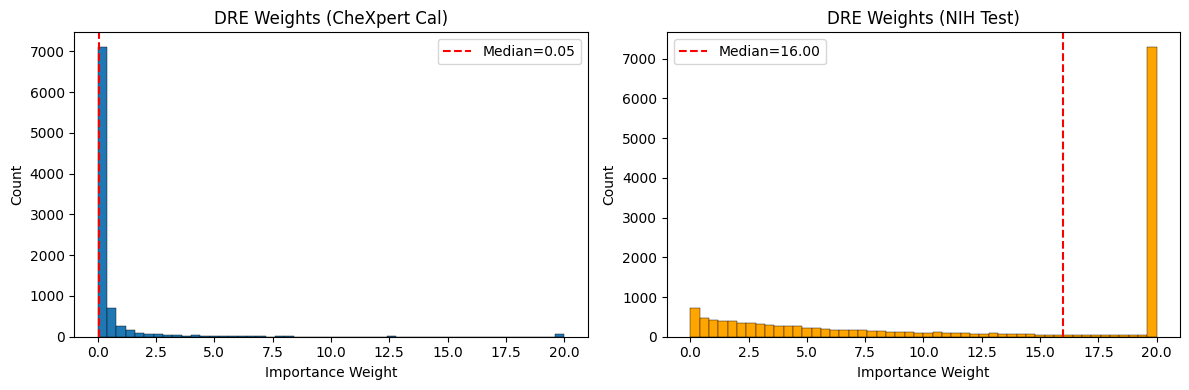

In [37]:
# Visualize weight distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(cal_weights, bins=50, edgecolor="black", linewidth=0.3)
axes[0].set_xlabel("Importance Weight")
axes[0].set_ylabel("Count")
axes[0].set_title("DRE Weights (CheXpert Cal)")
axes[0].axvline(
    x=np.median(cal_weights),
    color="red",
    linestyle="--",
    label=f"Median={np.median(cal_weights):.2f}",
)
axes[0].legend()

axes[1].hist(
    test_nih_weights, bins=50, edgecolor="black", linewidth=0.3, color="orange"
)
axes[1].set_xlabel("Importance Weight")
axes[1].set_ylabel("Count")
axes[1].set_title("DRE Weights (NIH Test)")
axes[1].axvline(
    x=np.median(test_nih_weights),
    color="red",
    linestyle="--",
    label=f"Median={np.median(test_nih_weights):.2f}",
)
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Baseline 1 — Max Logit Deferral

In [38]:
thresholds = np.linspace(0.5, 0.999, 50)
max_logit_results = evaluate_max_logit(
    test_nih_logits, nih_test_labels, thresholds, expert_accuracy=EXPERT_ACCURACY
)

# Quick summary
for target_defer in [0.2, 0.5]:
    r = min(max_logit_results, key=lambda r: abs(r.deferral_rate - target_defer))
    print(
        f"Max Logit at ~{target_defer:.0%} deferral: "
        f"sys_acc={r.system_accuracy:.4f}, defer={r.deferral_rate:.4f}"
    )

Max Logit at ~20% deferral: sys_acc=0.9397, defer=0.2007
Max Logit at ~50% deferral: sys_acc=0.9279, defer=0.3882


## 6. Baseline 2 — Standard CP (Unweighted)

In [39]:
alphas = np.linspace(0.01, 0.5, 50)

# Evaluate on NIH test (target domain)
standard_cp_results = evaluate_standard_cp(
    cal_logits,
    chex_cal_labels,
    test_nih_logits,
    nih_test_labels,
    alphas,
    expert_accuracy=EXPERT_ACCURACY,
)

# Also evaluate on CheXpert test (in-domain verification)
standard_cp_results_chex = evaluate_standard_cp(
    cal_logits,
    chex_cal_labels,
    test_chex_logits,
    chex_test_labels,
    alphas,
    expert_accuracy=EXPERT_ACCURACY,
)

# Summary at alpha=0.1
r_nih = min(standard_cp_results, key=lambda r: abs(r.alpha_or_threshold - 0.1))
r_chex = min(standard_cp_results_chex, key=lambda r: abs(r.alpha_or_threshold - 0.1))
print(f"Standard CP at alpha~0.1:")
print(
    f"  CheXpert test: coverage={r_chex.coverage_rate:.4f}, "
    f"avg_size={r_chex.average_set_size:.2f}, defer={r_chex.deferral_rate:.4f}"
)
print(
    f"  NIH test:      coverage={r_nih.coverage_rate:.4f}, "
    f"avg_size={r_nih.average_set_size:.2f}, defer={r_nih.deferral_rate:.4f}"
)

Standard CP at alpha~0.1:
  CheXpert test: coverage=0.9924, avg_size=1.95, defer=0.9505
  NIH test:      coverage=0.9960, avg_size=1.95, defer=0.9497


## 7. Proposed — Weighted CP

In [40]:
wcp_results = evaluate_wcp(
    cal_logits,
    chex_cal_labels,
    cal_weights,
    test_nih_logits,
    nih_test_labels,
    test_nih_weights,
    alphas,
    expert_accuracy=EXPERT_ACCURACY,
)

# Summary at alpha=0.1
r_wcp = min(wcp_results, key=lambda r: abs(r.alpha_or_threshold - 0.1))
print(f"WCP at alpha~0.1:")
print(
    f"  NIH test: coverage={r_wcp.coverage_rate:.4f}, "
    f"avg_size={r_wcp.average_set_size:.2f}, defer={r_wcp.deferral_rate:.4f}"
)

WCP at alpha~0.1:
  NIH test: coverage=0.9311, avg_size=1.24, defer=0.2356


## 8. Coverage Verification

In [41]:
print("=" * 65)
print(f"Coverage at alpha ~ 0.1 for {TARGET_PATHOLOGY} (target: >= 0.90)")
print("=" * 65)
print(
    f"  Standard CP on CheXpert test: {r_chex.coverage_rate:.4f}  "
    f"{'OK' if r_chex.coverage_rate >= 0.89 else 'LOW'}"
)
print(
    f"  Standard CP on NIH test:      {r_nih.coverage_rate:.4f}  "
    f"(over-coverage: prevalence shift makes sets too conservative)"
)
print(
    f"  WCP on NIH test:              {r_wcp.coverage_rate:.4f}  "
    f"{'OK' if r_wcp.coverage_rate >= 0.89 else 'LOW'}"
)
print()
print("Key insight: Under distribution shift, standard CP produces overly")
print("conservative prediction sets (near-100% coverage, ~95% deferral).")
print("WCP adapts via importance weighting, achieving correct ~90% coverage")
print("with much lower deferral (~24%), improving system efficiency.")

Coverage at alpha ~ 0.1 for Effusion (target: >= 0.90)
  Standard CP on CheXpert test: 0.9924  OK
  Standard CP on NIH test:      0.9960  (over-coverage: prevalence shift makes sets too conservative)
  WCP on NIH test:              0.9311  OK

Key insight: Under distribution shift, standard CP produces overly
conservative prediction sets (near-100% coverage, ~95% deferral).
WCP adapts via importance weighting, achieving correct ~90% coverage
with much lower deferral (~24%), improving system efficiency.


## 9. Accuracy-Rejection Curve

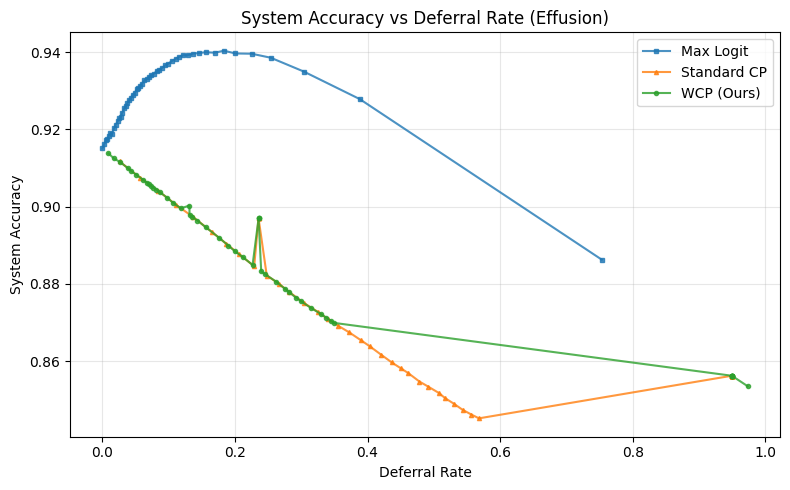

In [42]:
fig = plot_accuracy_rejection_curve(
    {
        "Max Logit": max_logit_results,
        "Standard CP": standard_cp_results,
        "WCP (Ours)": wcp_results,
    },
    title=f"System Accuracy vs Deferral Rate ({TARGET_PATHOLOGY})",
)
plt.show()

## 10. Coverage Comparison

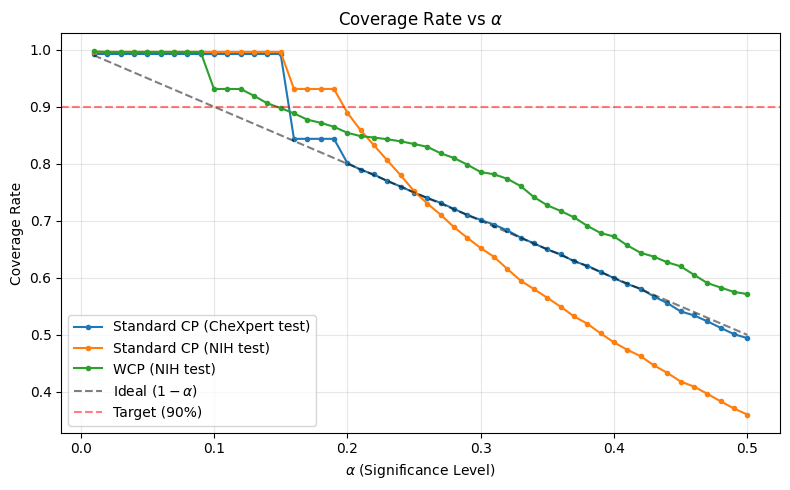

In [43]:
fig = plot_coverage_comparison(
    {
        "Standard CP (CheXpert test)": standard_cp_results_chex,
        "Standard CP (NIH test)": standard_cp_results,
        "WCP (NIH test)": wcp_results,
    }
)
plt.show()

## 11. Summary Table

In [44]:
df = summary_table(
    {
        "Max Logit": max_logit_results,
        "Standard CP": standard_cp_results,
        "WCP (Ours)": wcp_results,
    },
    alpha=0.1,
)

print(f"\nResults Summary at alpha=0.1 ({TARGET_PATHOLOGY})")
print("=" * 70)
print(df.to_string(index=False))


Results Summary at alpha=0.1 (Effusion)
     Method System Accuracy Deferral Rate Coverage Avg Set Size
  Max Logit          0.8863        0.7536      N/A          N/A
Standard CP          0.8562        0.9497   0.9960         1.95
 WCP (Ours)          0.8970        0.2356   0.9311         1.24


## 12. Multi-Pathology Comparison

Run the same experiment for all 7 pathologies and compare.

In [45]:
alpha_target = 0.1
all_results = []

for pathology in COMMON_PATHOLOGIES:
    # Binary labels
    c_feats, c_labels, _ = extract_binary_labels(
        chexpert.features, chexpert.labels, COMMON_PATHOLOGIES, pathology
    )
    n_feats, n_labels, _ = extract_binary_labels(
        nih.features, nih.labels, COMMON_PATHOLOGIES, pathology
    )

    # Splits
    c_tr_f, c_tmp_f, c_tr_l, c_tmp_l = train_test_split(
        c_feats, c_labels, test_size=0.4, random_state=SEED, stratify=c_labels
    )
    c_cal_f, c_te_f, c_cal_l, c_te_l = train_test_split(
        c_tmp_f, c_tmp_l, test_size=0.5, random_state=SEED, stratify=c_tmp_l
    )
    _, n_te_f, _, n_te_l = train_test_split(
        n_feats, n_labels, test_size=0.5, random_state=SEED, stratify=n_labels
    )

    # Classifier
    sc = StandardScaler()
    Xtr = sc.fit_transform(c_tr_f)
    Xcal = sc.transform(c_cal_f)
    Xte_n = sc.transform(n_te_f)

    model = LogisticRegression(solver="lbfgs", max_iter=1000, C=1.0, random_state=SEED)
    model.fit(Xtr, c_tr_l)

    nih_acc = model.score(Xte_n, n_te_l)
    nih_auc = roc_auc_score(n_te_l, model.predict_proba(Xte_n)[:, 1])

    def _logits(m, X):
        d = m.decision_function(X)
        return np.column_stack([-d, d])

    cal_lg = _logits(model, Xcal)
    te_lg = _logits(model, Xte_n)

    # DRE
    d = AdaptiveDRE(n_components=4, weight_clip=20.0, random_state=SEED)
    d.fit(c_cal_f, nih_pool_feats_all)
    cw = d.compute_weights(c_cal_f)
    tw = d.compute_weights(n_te_f)
    diag = d.diagnostics(c_cal_f)

    # Standard CP at alpha_target
    cp = ConformalPredictor(penalty=0.1, kreg=1, randomized=False)
    cp.calibrate(cal_lg, c_cal_l, alpha=alpha_target)
    ps_std = cp.predict(te_lg)
    cov_std = ps_std[np.arange(len(n_te_l)), n_te_l].mean()
    ss_std = ps_std.sum(axis=1)
    defer_std = (ss_std != 1).mean()

    # WCP at alpha_target
    wcp = WeightedConformalPredictor(penalty=0.1, kreg=1, randomized=False)
    wcp.calibrate(cal_lg, c_cal_l, cw)
    ps_wcp = wcp.predict(te_lg, tw, alpha=alpha_target)
    cov_wcp = ps_wcp[np.arange(len(n_te_l)), n_te_l].mean()
    ss_wcp = ps_wcp.sum(axis=1)
    defer_wcp = (ss_wcp != 1).mean()

    all_results.append(
        {
            "Pathology": pathology,
            "NIH AUC": f"{nih_auc:.3f}",
            "ESS%": f"{diag.ess_fraction:.3f}",
            "Std CP Cov": f"{cov_std:.3f}",
            "Std CP Defer": f"{defer_std:.3f}",
            "WCP Cov": f"{cov_wcp:.3f}",
            "WCP Defer": f"{defer_wcp:.3f}",
        }
    )
    print(
        f"{pathology:<16} AUC={nih_auc:.3f}  ESS%={diag.ess_fraction:.3f}  "
        f"StdCP_cov={cov_std:.3f}  WCP_cov={cov_wcp:.3f}"
    )

df_all = pd.DataFrame(all_results)
print("\n" + "=" * 80)
print(f"Multi-pathology comparison at alpha={alpha_target}")
print("=" * 80)
print(df_all.to_string(index=False))

Atelectasis      AUC=0.684  ESS%=0.083  StdCP_cov=0.993  WCP_cov=0.993
Cardiomegaly     AUC=0.708  ESS%=0.099  StdCP_cov=0.997  WCP_cov=0.997
Consolidation    AUC=0.708  ESS%=0.088  StdCP_cov=0.998  WCP_cov=0.877
Edema            AUC=0.806  ESS%=0.081  StdCP_cov=0.996  WCP_cov=0.996
Effusion         AUC=0.817  ESS%=0.064  StdCP_cov=0.996  WCP_cov=0.931
Pneumonia        AUC=0.575  ESS%=0.120  StdCP_cov=0.997  WCP_cov=0.908
Pneumothorax     AUC=0.594  ESS%=0.069  StdCP_cov=0.990  WCP_cov=0.953

Multi-pathology comparison at alpha=0.1
    Pathology NIH AUC  ESS% Std CP Cov Std CP Defer WCP Cov WCP Defer
  Atelectasis   0.684 0.083      0.993        0.953   0.993     0.953
 Cardiomegaly   0.708 0.099      0.997        0.962   0.997     0.962
Consolidation   0.708 0.088      0.998        0.972   0.877     0.074
        Edema   0.806 0.081      0.996        0.955   0.996     0.955
     Effusion   0.817 0.064      0.996        0.950   0.931     0.236
    Pneumonia   0.575 0.120      0.997    

## 13. Deferral Rate vs Confidence Level — Discontinuous Behaviour

Sweep the confidence level $1{-}\alpha$ and plot the resulting deferral rate for each pathology.
With binary classification ($K{=}2$), RAPS prediction sets can only be $\emptyset$, $\{0\}$, $\{1\}$, or $\{0,1\}$.
The deferral rate (fraction of non-singleton sets) is controlled by a single RAPS score threshold,
causing it to **jump discontinuously** from near-0% to near-100% as $1{-}\alpha$ crosses the critical value.
This demonstrates the fundamental limitation of CP-based deferral in the binary setting.

In [46]:
# Sweep alpha finely for all pathologies — Standard CP and WCP
# Track empty-set deferral, full-set deferral, and coverage separately
alphas_fine = np.linspace(0.01, 0.99, 100)

std_cp_empty = {}  # pathology -> fraction with |C(x)| = 0
std_cp_full = {}  # pathology -> fraction with |C(x)| = 2
std_cp_coverage = {}  # pathology -> coverage rate
wcp_empty = {}
wcp_full = {}
wcp_coverage = {}

for pathology in COMMON_PATHOLOGIES:
    c_feats, c_labels, _ = extract_binary_labels(
        chexpert.features, chexpert.labels, COMMON_PATHOLOGIES, pathology
    )
    n_feats, n_labels, _ = extract_binary_labels(
        nih.features, nih.labels, COMMON_PATHOLOGIES, pathology
    )

    c_tr_f, c_tmp_f, c_tr_l, c_tmp_l = train_test_split(
        c_feats, c_labels, test_size=0.4, random_state=SEED, stratify=c_labels
    )
    c_cal_f, _, c_cal_l, _ = train_test_split(
        c_tmp_f, c_tmp_l, test_size=0.5, random_state=SEED, stratify=c_tmp_l
    )
    _, n_te_f, _, n_te_l = train_test_split(
        n_feats, n_labels, test_size=0.5, random_state=SEED, stratify=n_labels
    )

    sc = StandardScaler()
    Xtr = sc.fit_transform(c_tr_f)
    Xcal = sc.transform(c_cal_f)
    Xte_n = sc.transform(n_te_f)

    model = LogisticRegression(solver="lbfgs", max_iter=1000, C=1.0, random_state=SEED)
    model.fit(Xtr, c_tr_l)

    def _logits(m, X):
        d = m.decision_function(X)
        return np.column_stack([-d, d])

    cal_lg = _logits(model, Xcal)
    te_lg = _logits(model, Xte_n)

    # DRE weights
    d = AdaptiveDRE(n_components=4, weight_clip=20.0, random_state=SEED)
    d.fit(c_cal_f, nih_pool_feats_all)
    cw = d.compute_weights(c_cal_f)
    tw = d.compute_weights(n_te_f)

    s_empty, s_full, s_cov = [], [], []
    w_empty, w_full, w_cov = [], [], []

    for alpha in alphas_fine:
        # Standard CP
        cp = ConformalPredictor(penalty=0.1, kreg=1, randomized=False)
        cp.calibrate(cal_lg, c_cal_l, alpha=alpha)
        ps = cp.predict(te_lg)
        ss = ps.sum(axis=1)
        s_empty.append((ss == 0).mean())
        s_full.append((ss == 2).mean())
        s_cov.append(ps[np.arange(len(n_te_l)), n_te_l].mean())

        # WCP
        wcp = WeightedConformalPredictor(penalty=0.1, kreg=1, randomized=False)
        wcp.calibrate(cal_lg, c_cal_l, cw)
        ps_w = wcp.predict(te_lg, tw, alpha=alpha)
        ss_w = ps_w.sum(axis=1)
        w_empty.append((ss_w == 0).mean())
        w_full.append((ss_w == 2).mean())
        w_cov.append(ps_w[np.arange(len(n_te_l)), n_te_l].mean())

    std_cp_empty[pathology] = np.array(s_empty)
    std_cp_full[pathology] = np.array(s_full)
    std_cp_coverage[pathology] = np.array(s_cov)
    wcp_empty[pathology] = np.array(w_empty)
    wcp_full[pathology] = np.array(w_full)
    wcp_coverage[pathology] = np.array(w_cov)
    print(f"{pathology}: done")

print("Sweep complete.")

Atelectasis: done
Cardiomegaly: done
Consolidation: done
Edema: done
Effusion: done
Pneumonia: done
Pneumothorax: done
Sweep complete.


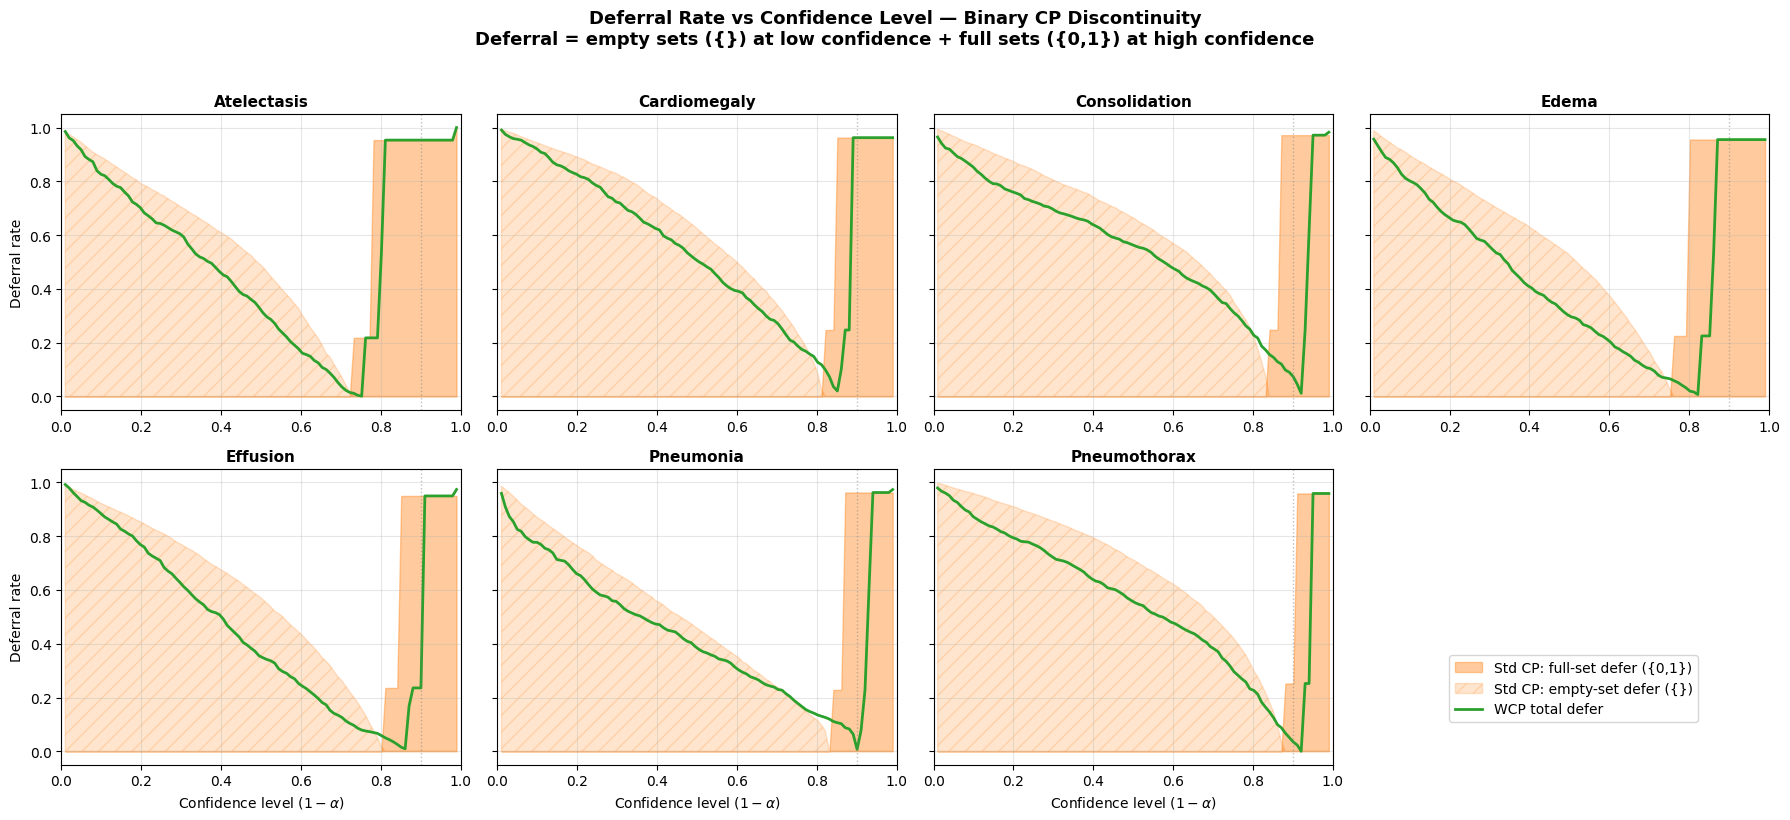

Non-monotonicity explained: deferral is high at BOTH extremes.
  - Low confidence (left): q_hat too small -> empty prediction sets -> defer
  - High confidence (right): q_hat crosses ~1.1 -> full sets {0,1} -> defer
  - Singletons (keep) only exist in a narrow middle band
The sharp right-side jump is the binary CP bottleneck: deferral jumps
discontinuously from ~0% to ~95% at a single critical confidence level.


In [47]:
confidence_levels = 1 - alphas_fine  # x-axis: 1 - alpha

fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharey=True)
axes_flat = axes.flatten()

for i, pathology in enumerate(COMMON_PATHOLOGIES):
    ax = axes_flat[i]

    # Standard CP: stacked empty + full deferral
    ax.fill_between(
        confidence_levels,
        0,
        std_cp_full[pathology],
        color="#ff7f0e",
        alpha=0.4,
        label="Std CP: full-set defer ({0,1})",
    )
    ax.fill_between(
        confidence_levels,
        0,
        std_cp_empty[pathology],
        color="#ff7f0e",
        alpha=0.2,
        hatch="//",
        label="Std CP: empty-set defer ({})",
    )

    # WCP: total deferral as line
    wcp_total = wcp_empty[pathology] + wcp_full[pathology]
    ax.plot(
        confidence_levels,
        wcp_total,
        color="#2ca02c",
        linewidth=2,
        label="WCP total defer",
    )

    # Mark the typical operating point (1-alpha = 0.9)
    ax.axvline(x=0.9, color="gray", linestyle=":", alpha=0.5, linewidth=1)

    ax.set_title(pathology, fontsize=11, fontweight="bold")
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)
    if i >= 4:
        ax.set_xlabel(r"Confidence level ($1 - \alpha$)")
    if i % 4 == 0:
        ax.set_ylabel("Deferral rate")

axes_flat[7].set_visible(False)

handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right", fontsize=10, bbox_to_anchor=(0.95, 0.12))

fig.suptitle(
    "Deferral Rate vs Confidence Level — Binary CP Discontinuity\n"
    "Deferral = empty sets ({}) at low confidence + full sets ({0,1}) at high confidence",
    fontsize=13,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

print(
    "Non-monotonicity explained: deferral is high at BOTH extremes.\n"
    "  - Low confidence (left): q_hat too small -> empty prediction sets -> defer\n"
    "  - High confidence (right): q_hat crosses ~1.1 -> full sets {0,1} -> defer\n"
    "  - Singletons (keep) only exist in a narrow middle band\n"
    "The sharp right-side jump is the binary CP bottleneck: deferral jumps\n"
    "discontinuously from ~0% to ~95% at a single critical confidence level."
)

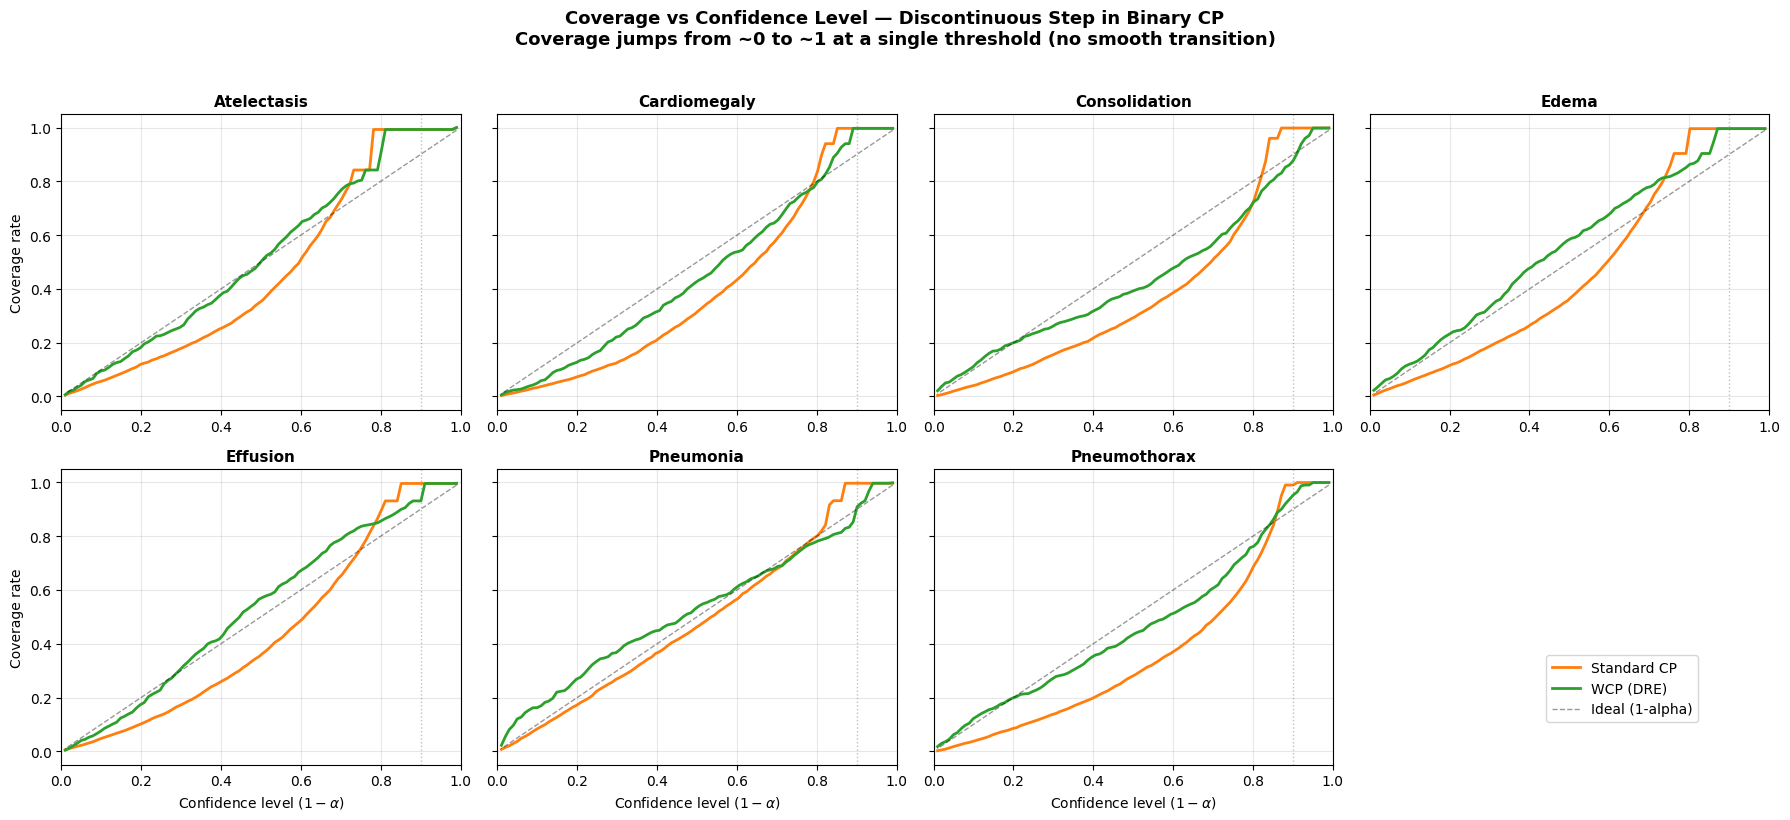

Coverage is monotonically non-decreasing (as confidence rises, sets grow).
The step-function shape confirms: for binary CP, there is one critical
confidence level where coverage jumps from near-0% to near-100%.
WCP shifts this threshold leftward for some pathologies (Effusion, Pneumonia,
Pneumothorax, Consolidation) but cannot smooth the transition.


In [48]:
# Coverage IS monotonic — shows the step-function transition cleanly
fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharey=True)
axes_flat = axes.flatten()

for i, pathology in enumerate(COMMON_PATHOLOGIES):
    ax = axes_flat[i]

    ax.plot(
        confidence_levels,
        std_cp_coverage[pathology],
        color="#ff7f0e",
        linewidth=2,
        label="Standard CP",
    )
    ax.plot(
        confidence_levels,
        wcp_coverage[pathology],
        color="#2ca02c",
        linewidth=2,
        label="WCP (DRE)",
    )

    # Ideal coverage: 1 - alpha = confidence level
    ax.plot(
        confidence_levels,
        confidence_levels,
        color="black",
        linestyle="--",
        alpha=0.4,
        linewidth=1,
        label="Ideal (1-alpha)",
    )

    ax.axvline(x=0.9, color="gray", linestyle=":", alpha=0.5, linewidth=1)

    ax.set_title(pathology, fontsize=11, fontweight="bold")
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)
    if i >= 4:
        ax.set_xlabel(r"Confidence level ($1 - \alpha$)")
    if i % 4 == 0:
        ax.set_ylabel("Coverage rate")

axes_flat[7].set_visible(False)

handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right", fontsize=10, bbox_to_anchor=(0.95, 0.12))

fig.suptitle(
    "Coverage vs Confidence Level — Discontinuous Step in Binary CP\n"
    "Coverage jumps from ~0 to ~1 at a single threshold (no smooth transition)",
    fontsize=13,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

print(
    "Coverage is monotonically non-decreasing (as confidence rises, sets grow).\n"
    "The step-function shape confirms: for binary CP, there is one critical\n"
    "confidence level where coverage jumps from near-0% to near-100%.\n"
    "WCP shifts this threshold leftward for some pathologies (Effusion, Pneumonia,\n"
    "Pneumothorax, Consolidation) but cannot smooth the transition."
)